In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_17054/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


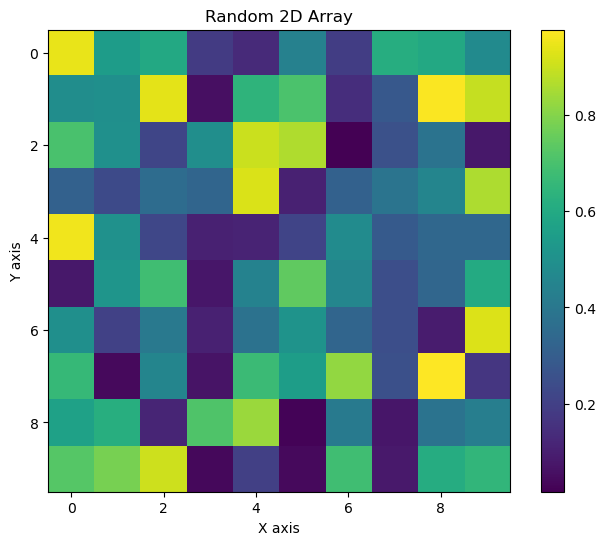

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
 # dvs 데이터 시각화 코드
 ##############################################################################################
            # mapping = {
            #     0: 'Hand Clapping',
            #     1: 'Right Hand Wave',
            #     2: 'Left Hand Wave',
            #     3: 'Right Arm CW',
            #     4: 'Right Arm CCW',
            #     5: 'Left Arm CW',
            #     6: 'Left Arm CCW',
            #     7: 'Arm Roll',
            #     8: 'Air Drums',
            #     9: 'Air Guitar',
            #     10: 'Other'
            # }
def dvs_visualization(inputs, labels, TIME, BATCH):
            
    what_input = random.randint(0, BATCH - 1)
    inputs_for_view = inputs.permute(1, 0, 2, 3, 4)
    for i in range(TIME):
        # 예시 데이터 생성
        data1 = inputs_for_view[what_input][i][0].numpy()  # torch tensor를 numpy 배열로 변환
        data2 = inputs_for_view[what_input][i][1].numpy()  # torch tensor를 numpy 배열로 변환

        # 데이터 플로팅
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1행 2열의 subplot 생성

        # 첫 번째 subplot에 데이터1 플로팅
        im1 = axs[0].imshow(data1, cmap='viridis', interpolation='nearest')
        axs[0].set_title(f'Channel 0\nLabel: {labels[what_input]}  Time: {i}')  # 라벨값 맵핑하여 제목에 추가
        axs[0].set_xlabel('X axis')
        axs[0].set_ylabel('Y axis')
        axs[0].grid(False)
        fig.colorbar(im1, ax=axs[0])  # Color bar 추가

        # 두 번째 subplot에 데이터2 플로팅
        im2 = axs[1].imshow(data2, cmap='viridis', interpolation='nearest')
        axs[1].set_title(f'Channel 1\nLabel: {labels[what_input]}  Time: {i}')  # 라벨값 맵핑하여 제목에 추가
        axs[1].set_xlabel('X axis')
        axs[1].set_ylabel('Y axis')
        axs[1].grid(False)
        fig.colorbar(im2, ax=axs[1])  # Color bar 추가

        plt.tight_layout()  # subplot 간 간격 조정
        plt.show()
    sys.exit("종료")

######################################################################################################

In [5]:
def my_snn_system(devices = "0,1,2,3",
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True

    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    
    wandb.init(project= f'my_snn {unique_name}', config=hyperparameters)
    wandb.run.name = unique_name



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                print('past_in_channel', past_in_channel)
                print('bias_param', bias_param)
                print('in_channel', in_channel)
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on,
                     OTTT_sWS_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    # wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            # print('inputs',inputs.size(),'\nlabels',labels.size())
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
                
            # # DVS에서 time duration으로 잘랐을 때는 timestep 맞춰주자 --> data 가져올 때, 그 함수 안에서 처리함.
            # if (dvs_duration > 0): 
            #     # inputs.size(1)를 TIME으로 맞추기
            #     T, *spatial_dims = inputs.shape
            #     if T > TIME:
            #         inputs = inputs[:TIME]
            #     else:
            #         inputs = torch.cat([inputs, torch.zeros(TIME - T, *spatial_dims)], dim=0)
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################


            ## device로 보내주기 ######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################


            # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width] 
            #################################################################################################


            ### input --> net --> output #####################################################
            outputs = net(inputs)
            ##################################################################################

            ## net 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)
            #######################################################################
            


            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted[0:batch] == labels).sum().item()
            tr_total += total
            tr_correct += correct
            iter_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter_acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            ## loss, backward ##########################################
            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()
            ############################################################

            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            

            ## weight 업데이트!! ##################################
            optimizer.step()
            ################################################################


            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            iterator.set_description(f"iter_acc: {iter_acc_string}, iter_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            # # 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기)
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)

            np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    wandb.finish()
    #======== EPOCH END ==========================================================================================


In [6]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

unique_name = 'main2' ## 이거 설정하면 새로운 경로에 모두 save

my_snn_system(  devices = "4",
                unique_name = unique_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 0.6, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace()
      (1): LIF_layer_trace()
      (2): Scale()
      (3): SYNAPSE_CONV_trace()
      (4): LIF_layer_trace()
      (5): Scale()
      (6): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (7): SYNAPSE_CONV_trace()
      (8): LIF_layer_trace()
      (9): Scale()
      (10): SYNAPSE_CONV_trace()
      (11): LIF_layer_trace()
      (12): Scale()
      (13): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (14): SYNAPSE_CONV_trace()
      (15): LIF_layer_trace()
      (16): Scale()
      (17): SYNAPSE_CONV_trace()
      (18): LIF_layer_trace()
      (19): Scale()
      (20): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (21): SYNAPSE_CONV_trace(

iter_acc: 0-390/391 iter_acc: 13.75%, lr=['0.6'], iter_loss: 0.35675233602523804, val_acc: 11.61%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.65998816490173 seconds

EPOCH 1



iter_acc: 1-390/391 iter_acc: 43.75%, lr=['0.5999835508096536'], iter_loss: 0.25316527485847473, val_acc: 48.22%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 196.83038783073425 seconds

EPOCH 2



iter_acc: 2-390/391 iter_acc: 45.00%, lr=['0.5999342050424536'], iter_loss: 0.22914111614227295, val_acc: 60.46%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.30563759803772 seconds

EPOCH 3



iter_acc: 3-390/391 iter_acc: 61.25%, lr=['0.5998519681097194'], iter_loss: 0.19445030391216278, val_acc: 65.63%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.82374572753906 seconds

EPOCH 4



iter_acc: 4-390/391 iter_acc: 66.25%, lr=['0.5997368490296574'], iter_loss: 0.1599118411540985, val_acc: 70.41%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.88119506835938 seconds

EPOCH 5



iter_acc: 5-390/391 iter_acc: 72.50%, lr=['0.599588860426372'], iter_loss: 0.1499163806438446, val_acc: 74.83%: 100%|██████████| 391/391 [03:17<00:00,  1.97it/s] 

epoch_time: 198.1494336128235 seconds

EPOCH 6



iter_acc: 6-390/391 iter_acc: 73.75%, lr=['0.5994080185284814'], iter_loss: 0.13429908454418182, val_acc: 76.43%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.3663341999054 seconds

EPOCH 7



iter_acc: 7-390/391 iter_acc: 81.25%, lr=['0.5991943431673372'], iter_loss: 0.12525157630443573, val_acc: 77.16%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.86359214782715 seconds

EPOCH 8



iter_acc: 8-390/391 iter_acc: 75.00%, lr=['0.5989478577748512'], iter_loss: 0.13445109128952026, val_acc: 80.96%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 197.11748456954956 seconds

EPOCH 9



iter_acc: 9-390/391 iter_acc: 83.75%, lr=['0.5986685893809238'], iter_loss: 0.12601274251937866, val_acc: 79.80%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.89203476905823 seconds

EPOCH 10



iter_acc: 10-390/391 iter_acc: 82.50%, lr=['0.5983565686104818'], iter_loss: 0.11431466042995453, val_acc: 81.74%: 100%|██████████| 391/391 [03:41<00:00,  1.76it/s]

epoch_time: 221.707172870636 seconds

EPOCH 11



iter_acc: 11-390/391 iter_acc: 82.50%, lr=['0.5980118296801188'], iter_loss: 0.10320394486188889, val_acc: 82.35%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.96981048583984 seconds

EPOCH 12



iter_acc: 12-390/391 iter_acc: 83.75%, lr=['0.5976344103943433'], iter_loss: 0.09766291081905365, val_acc: 84.09%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 200.08946084976196 seconds

EPOCH 13



iter_acc: 13-390/391 iter_acc: 75.00%, lr=['0.597224352141433'], iter_loss: 0.12136155366897583, val_acc: 84.30%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 199.00372099876404 seconds

EPOCH 14



iter_acc: 14-390/391 iter_acc: 75.00%, lr=['0.5967816998888964'], iter_loss: 0.12031862139701843, val_acc: 84.07%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.8117218017578 seconds

EPOCH 15



iter_acc: 15-390/391 iter_acc: 85.00%, lr=['0.5963065021785412'], iter_loss: 0.07853494584560394, val_acc: 85.42%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]

epoch_time: 201.34304690361023 seconds

EPOCH 16



iter_acc: 16-390/391 iter_acc: 78.75%, lr=['0.5957988111211514'], iter_loss: 0.10249122232198715, val_acc: 85.81%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.31457781791687 seconds

EPOCH 17



iter_acc: 17-390/391 iter_acc: 88.75%, lr=['0.5952586823907724'], iter_loss: 0.08562265336513519, val_acc: 84.98%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.3099217414856 seconds

EPOCH 18



iter_acc: 18-390/391 iter_acc: 81.25%, lr=['0.5946861752186066'], iter_loss: 0.11107590794563293, val_acc: 86.21%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.22927284240723 seconds

EPOCH 19



iter_acc: 19-390/391 iter_acc: 85.00%, lr=['0.5940813523865165'], iter_loss: 0.09411297738552094, val_acc: 85.59%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.38824248313904 seconds

EPOCH 20



iter_acc: 20-390/391 iter_acc: 85.00%, lr=['0.5934442802201416'], iter_loss: 0.08139362931251526, val_acc: 85.78%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.9784562587738 seconds

EPOCH 21



iter_acc: 21-390/391 iter_acc: 80.00%, lr=['0.5927750285816241'], iter_loss: 0.09051527827978134, val_acc: 86.50%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.65750765800476 seconds

EPOCH 22



iter_acc: 22-390/391 iter_acc: 91.25%, lr=['0.592073670861948'], iter_loss: 0.07170380651950836, val_acc: 87.15%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.89354348182678 seconds

EPOCH 23



iter_acc: 23-390/391 iter_acc: 85.00%, lr=['0.5913402839728907'], iter_loss: 0.0989178866147995, val_acc: 86.93%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]  

epoch_time: 197.71107840538025 seconds

EPOCH 24



iter_acc: 24-390/391 iter_acc: 88.75%, lr=['0.5905749483385893'], iter_loss: 0.06517995893955231, val_acc: 88.04%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.9962215423584 seconds

EPOCH 25



iter_acc: 25-390/391 iter_acc: 88.75%, lr=['0.5897777478867203'], iter_loss: 0.06907397508621216, val_acc: 88.20%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.2864067554474 seconds

EPOCH 26



iter_acc: 26-390/391 iter_acc: 90.00%, lr=['0.5889487700392974'], iter_loss: 0.07140260934829712, val_acc: 88.45%: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s] 

epoch_time: 208.472026348114 seconds

EPOCH 27



iter_acc: 27-390/391 iter_acc: 81.25%, lr=['0.5880881057030828'], iter_loss: 0.08656104654073715, val_acc: 87.99%: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s] 

epoch_time: 265.56671142578125 seconds

EPOCH 28



iter_acc: 28-390/391 iter_acc: 85.00%, lr=['0.58719584925962'], iter_loss: 0.07699279487133026, val_acc: 88.18%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.65480136871338 seconds

EPOCH 29



iter_acc: 29-390/391 iter_acc: 91.25%, lr=['0.5862720985548829'], iter_loss: 0.06371881067752838, val_acc: 88.24%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.6768774986267 seconds

EPOCH 30



iter_acc: 30-390/391 iter_acc: 86.25%, lr=['0.585316954888546'], iter_loss: 0.07579551637172699, val_acc: 89.00%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 200.1309175491333 seconds

EPOCH 31



iter_acc: 31-390/391 iter_acc: 93.75%, lr=['0.5843305230028756'], iter_loss: 0.052916161715984344, val_acc: 88.40%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.62940764427185 seconds

EPOCH 32



iter_acc: 32-390/391 iter_acc: 90.00%, lr=['0.5833129110712442'], iter_loss: 0.06549860537052155, val_acc: 88.62%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 199.00517439842224 seconds

EPOCH 33



iter_acc: 33-390/391 iter_acc: 95.00%, lr=['0.5822642306862674'], iter_loss: 0.04474177956581116, val_acc: 88.68%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.77720093727112 seconds

EPOCH 34



iter_acc: 34-390/391 iter_acc: 93.75%, lr=['0.5811845968475672'], iter_loss: 0.06128683313727379, val_acc: 89.14%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.23897981643677 seconds

EPOCH 35



iter_acc: 35-390/391 iter_acc: 91.25%, lr=['0.5800741279491602'], iter_loss: 0.058452777564525604, val_acc: 89.02%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.3793921470642 seconds

EPOCH 36



iter_acc: 36-390/391 iter_acc: 87.50%, lr=['0.5789329457664751'], iter_loss: 0.06789396703243256, val_acc: 89.34%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 201.1151430606842 seconds

EPOCH 37



iter_acc: 37-390/391 iter_acc: 92.50%, lr=['0.5777611754429982'], iter_loss: 0.055572450160980225, val_acc: 89.24%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 198.07883763313293 seconds

EPOCH 38



iter_acc: 38-390/391 iter_acc: 95.00%, lr=['0.57655894547655'], iter_loss: 0.05055395886301994, val_acc: 89.40%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.93221259117126 seconds

EPOCH 39



iter_acc: 39-390/391 iter_acc: 93.75%, lr=['0.5753263877051942'], iter_loss: 0.04196092486381531, val_acc: 89.08%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.58557653427124 seconds

EPOCH 40



iter_acc: 40-390/391 iter_acc: 88.75%, lr=['0.5740636372927801'], iter_loss: 0.06564107537269592, val_acc: 88.95%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.23601961135864 seconds

EPOCH 41



iter_acc: 41-390/391 iter_acc: 92.50%, lr=['0.5727708327141204'], iter_loss: 0.058439865708351135, val_acc: 89.60%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.30482149124146 seconds

EPOCH 42



iter_acc: 42-390/391 iter_acc: 93.75%, lr=['0.5714481157398057'], iter_loss: 0.0497337207198143, val_acc: 89.42%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]  

epoch_time: 197.63092756271362 seconds

EPOCH 43



iter_acc: 43-390/391 iter_acc: 91.25%, lr=['0.5700956314206579'], iter_loss: 0.05145282670855522, val_acc: 89.95%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.17346906661987 seconds

EPOCH 44



iter_acc: 44-390/391 iter_acc: 96.25%, lr=['0.5687135280718236'], iter_loss: 0.04302313178777695, val_acc: 90.16%: 100%|██████████| 391/391 [03:17<00:00,  1.97it/s] 

epoch_time: 198.140971660614 seconds

EPOCH 45



iter_acc: 45-390/391 iter_acc: 90.00%, lr=['0.5673019572565101'], iter_loss: 0.06768769025802612, val_acc: 89.78%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.92442917823792 seconds

EPOCH 46



iter_acc: 46-390/391 iter_acc: 88.75%, lr=['0.5658610737693641'], iter_loss: 0.06551742553710938, val_acc: 89.67%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.27485632896423 seconds

EPOCH 47



iter_acc: 47-390/391 iter_acc: 97.50%, lr=['0.5643910356194973'], iter_loss: 0.041818708181381226, val_acc: 89.92%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]

epoch_time: 200.3262276649475 seconds

EPOCH 48



iter_acc: 48-390/391 iter_acc: 95.00%, lr=['0.5628920040131588'], iter_loss: 0.058731935918331146, val_acc: 89.41%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.86646461486816 seconds

EPOCH 49



iter_acc: 49-390/391 iter_acc: 91.25%, lr=['0.5613641433360566'], iter_loss: 0.052461784332990646, val_acc: 89.68%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]

epoch_time: 200.36558938026428 seconds

EPOCH 50



iter_acc: 50-390/391 iter_acc: 90.00%, lr=['0.5598076211353313'], iter_loss: 0.06759364902973175, val_acc: 89.76%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.762188911438 seconds

EPOCH 51



iter_acc: 51-390/391 iter_acc: 92.50%, lr=['0.5582226081011828'], iter_loss: 0.05041767656803131, val_acc: 90.01%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.94486713409424 seconds

EPOCH 52



iter_acc: 52-390/391 iter_acc: 90.00%, lr=['0.5566092780481517'], iter_loss: 0.05710957571864128, val_acc: 89.96%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]  

epoch_time: 200.41413569450378 seconds

EPOCH 53



iter_acc: 53-390/391 iter_acc: 93.75%, lr=['0.5549678078960589'], iter_loss: 0.05348369479179382, val_acc: 90.15%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.40237879753113 seconds

EPOCH 54



iter_acc: 54-390/391 iter_acc: 93.75%, lr=['0.5532983776506043'], iter_loss: 0.0415259413421154, val_acc: 90.28%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]  

epoch_time: 199.85903668403625 seconds

EPOCH 55



iter_acc: 55-390/391 iter_acc: 97.50%, lr=['0.551601170383627'], iter_loss: 0.045839905738830566, val_acc: 90.41%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.63042044639587 seconds

EPOCH 56



iter_acc: 56-390/391 iter_acc: 98.75%, lr=['0.5498763722130297'], iter_loss: 0.037281326949596405, val_acc: 90.13%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.6045436859131 seconds

EPOCH 57



iter_acc: 57-390/391 iter_acc: 93.75%, lr=['0.5481241722823683'], iter_loss: 0.044092293828725815, val_acc: 90.38%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]

epoch_time: 203.0195505619049 seconds

EPOCH 58



iter_acc: 58-390/391 iter_acc: 95.00%, lr=['0.546344762740111'], iter_loss: 0.04813643917441368, val_acc: 90.31%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 200.085688829422 seconds

EPOCH 59



iter_acc: 59-390/391 iter_acc: 96.25%, lr=['0.544538338718566'], iter_loss: 0.04301401227712631, val_acc: 90.24%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]  

epoch_time: 200.69886565208435 seconds

EPOCH 60



iter_acc: 60-390/391 iter_acc: 100.00%, lr=['0.542705098312484'], iter_loss: 0.03102259337902069, val_acc: 90.62%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.36084628105164 seconds

EPOCH 61



iter_acc: 61-390/391 iter_acc: 92.50%, lr=['0.5408452425573341'], iter_loss: 0.049173127859830856, val_acc: 90.39%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 198.0572214126587 seconds

EPOCH 62



iter_acc: 62-390/391 iter_acc: 93.75%, lr=['0.5389589754072586'], iter_loss: 0.04802824184298515, val_acc: 90.61%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.92060160636902 seconds

EPOCH 63



iter_acc: 63-390/391 iter_acc: 92.50%, lr=['0.5370465037127067'], iter_loss: 0.047433122992515564, val_acc: 90.79%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.9486379623413 seconds

EPOCH 64



iter_acc: 64-390/391 iter_acc: 98.75%, lr=['0.5351080371977516'], iter_loss: 0.030357245355844498, val_acc: 90.59%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.44138717651367 seconds

EPOCH 65



iter_acc: 65-390/391 iter_acc: 93.75%, lr=['0.5331437884370909'], iter_loss: 0.05895845592021942, val_acc: 90.39%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]  

epoch_time: 201.28025007247925 seconds

EPOCH 66



iter_acc: 66-390/391 iter_acc: 97.50%, lr=['0.5311539728327364'], iter_loss: 0.04103866219520569, val_acc: 90.95%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.2762520313263 seconds

EPOCH 67



iter_acc: 67-390/391 iter_acc: 90.00%, lr=['0.5291388085903923'], iter_loss: 0.055338263511657715, val_acc: 90.86%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.94723796844482 seconds

EPOCH 68



iter_acc: 68-390/391 iter_acc: 95.00%, lr=['0.5270985166955265'], iter_loss: 0.04433740675449371, val_acc: 89.97%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.84782242774963 seconds

EPOCH 69



iter_acc: 69-390/391 iter_acc: 96.25%, lr=['0.5250333208891375'], iter_loss: 0.04022577404975891, val_acc: 90.84%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s] 

epoch_time: 206.60185265541077 seconds

EPOCH 70



iter_acc: 70-390/391 iter_acc: 93.75%, lr=['0.5229434476432179'], iter_loss: 0.052601542323827744, val_acc: 90.66%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]

epoch_time: 202.84457898139954 seconds

EPOCH 71



iter_acc: 71-390/391 iter_acc: 93.75%, lr=['0.5208291261359198'], iter_loss: 0.050742100924253464, val_acc: 90.37%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.9073281288147 seconds

EPOCH 72



iter_acc: 72-390/391 iter_acc: 93.75%, lr=['0.518690588226423'], iter_loss: 0.04715844988822937, val_acc: 90.98%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.78320622444153 seconds

EPOCH 73



iter_acc: 73-390/391 iter_acc: 93.75%, lr=['0.5165280684295082'], iter_loss: 0.04710949584841728, val_acc: 91.13%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 203.0246057510376 seconds

EPOCH 74



iter_acc: 74-390/391 iter_acc: 100.00%, lr=['0.5143418038898405'], iter_loss: 0.029735136777162552, val_acc: 90.91%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s]

epoch_time: 210.67054843902588 seconds

EPOCH 75



iter_acc: 75-390/391 iter_acc: 98.75%, lr=['0.5121320343559638'], iter_loss: 0.04146648198366165, val_acc: 90.72%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]  

epoch_time: 206.89128828048706 seconds

EPOCH 76



iter_acc: 76-390/391 iter_acc: 98.75%, lr=['0.5098990021540092'], iter_loss: 0.03443948179483414, val_acc: 90.57%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s]  

epoch_time: 210.61408495903015 seconds

EPOCH 77



iter_acc: 77-390/391 iter_acc: 92.50%, lr=['0.5076429521611215'], iter_loss: 0.056808918714523315, val_acc: 90.76%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s]

epoch_time: 210.67531943321228 seconds

EPOCH 78



iter_acc: 78-390/391 iter_acc: 92.50%, lr=['0.5053641317786062'], iter_loss: 0.0529266893863678, val_acc: 90.78%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]  

epoch_time: 211.41337418556213 seconds

EPOCH 79



iter_acc: 79-390/391 iter_acc: 95.00%, lr=['0.5030627909047978'], iter_loss: 0.04422352835536003, val_acc: 90.92%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s]  

epoch_time: 204.0932924747467 seconds

EPOCH 80



iter_acc: 80-390/391 iter_acc: 96.25%, lr=['0.500739181907657'], iter_loss: 0.04427504539489746, val_acc: 90.95%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.5982222557068 seconds

EPOCH 81



iter_acc: 81-390/391 iter_acc: 97.50%, lr=['0.4983935595970951'], iter_loss: 0.03829779848456383, val_acc: 91.34%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]  

epoch_time: 205.0654194355011 seconds

EPOCH 82



iter_acc: 82-390/391 iter_acc: 98.75%, lr=['0.49602618119703124'], iter_loss: 0.03048393689095974, val_acc: 91.41%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 203.03015398979187 seconds

EPOCH 83



iter_acc: 83-390/391 iter_acc: 97.50%, lr=['0.4936373063171847'], iter_loss: 0.03677079826593399, val_acc: 90.92%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.76999688148499 seconds

EPOCH 84



iter_acc: 84-390/391 iter_acc: 98.75%, lr=['0.4912271969246065'], iter_loss: 0.03303522616624832, val_acc: 91.30%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]  

epoch_time: 207.03666067123413 seconds

EPOCH 85



iter_acc: 85-390/391 iter_acc: 97.50%, lr=['0.48879611731495076'], iter_loss: 0.031568072736263275, val_acc: 91.21%: 100%|██████████| 391/391 [03:22<00:00,  1.94it/s] 

epoch_time: 202.16124320030212 seconds

EPOCH 86



iter_acc: 86-390/391 iter_acc: 95.00%, lr=['0.4863443340834927'], iter_loss: 0.04199609160423279, val_acc: 91.08%: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s]  

epoch_time: 208.12400674819946 seconds

EPOCH 87



iter_acc: 87-390/391 iter_acc: 95.00%, lr=['0.48387211609589253'], iter_loss: 0.041882336139678955, val_acc: 91.02%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s] 

epoch_time: 204.56840825080872 seconds

EPOCH 88



iter_acc: 88-390/391 iter_acc: 98.75%, lr=['0.48137973445871207'], iter_loss: 0.03180982172489166, val_acc: 91.27%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]  

epoch_time: 201.66405081748962 seconds

EPOCH 89



iter_acc: 89-390/391 iter_acc: 100.00%, lr=['0.4788674624896843'], iter_loss: 0.02497837506234646, val_acc: 91.30%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.62981295585632 seconds

EPOCH 90



iter_acc: 90-390/391 iter_acc: 96.25%, lr=['0.4763355756877415'], iter_loss: 0.03758327662944794, val_acc: 91.20%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.93259811401367 seconds

EPOCH 91



iter_acc: 91-390/391 iter_acc: 98.75%, lr=['0.4737843517028032'], iter_loss: 0.029392417520284653, val_acc: 91.76%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s] 

epoch_time: 204.7481780052185 seconds

EPOCH 92



iter_acc: 92-390/391 iter_acc: 97.50%, lr=['0.47121407030532914'], iter_loss: 0.04073534160852432, val_acc: 91.25%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s] 

epoch_time: 203.35783982276917 seconds

EPOCH 93



iter_acc: 93-390/391 iter_acc: 92.50%, lr=['0.4686250133556388'], iter_loss: 0.055567435920238495, val_acc: 91.28%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.53817200660706 seconds

EPOCH 94



iter_acc: 94-390/391 iter_acc: 93.75%, lr=['0.46601746477300277'], iter_loss: 0.055769991129636765, val_acc: 90.66%: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s] 

epoch_time: 208.94620847702026 seconds

EPOCH 95



iter_acc: 95-390/391 iter_acc: 92.50%, lr=['0.46339171050450767'], iter_loss: 0.05646945536136627, val_acc: 91.17%: 100%|██████████| 391/391 [03:29<00:00,  1.86it/s]  

epoch_time: 209.96070218086243 seconds

EPOCH 96



iter_acc: 96-390/391 iter_acc: 97.50%, lr=['0.4607480384936985'], iter_loss: 0.043121010065078735, val_acc: 91.15%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]

epoch_time: 209.75279545783997 seconds

EPOCH 97



iter_acc: 97-390/391 iter_acc: 96.25%, lr=['0.45808673864900284'], iter_loss: 0.03745650500059128, val_acc: 91.51%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]  

epoch_time: 209.49855160713196 seconds

EPOCH 98



iter_acc: 98-390/391 iter_acc: 97.50%, lr=['0.4554081028119386'], iter_loss: 0.03336164727807045, val_acc: 91.06%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]  

epoch_time: 211.82172632217407 seconds

EPOCH 99



iter_acc: 99-390/391 iter_acc: 97.50%, lr=['0.4527124247251109'], iter_loss: 0.03428390249609947, val_acc: 91.31%: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s] 

epoch_time: 205.62282991409302 seconds

EPOCH 100



iter_acc: 100-390/391 iter_acc: 98.75%, lr=['0.4499999999999995'], iter_loss: 0.03860492631793022, val_acc: 91.56%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]  

epoch_time: 209.5515112876892 seconds

EPOCH 101



iter_acc: 101-390/391 iter_acc: 98.75%, lr=['0.4472711260845418'], iter_loss: 0.029731690883636475, val_acc: 91.14%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.78535985946655 seconds

EPOCH 102



iter_acc: 102-390/391 iter_acc: 97.50%, lr=['0.4445261022305141'], iter_loss: 0.03972768038511276, val_acc: 91.48%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]  

epoch_time: 200.97274208068848 seconds

EPOCH 103



iter_acc: 103-390/391 iter_acc: 96.25%, lr=['0.4417652294607158'], iter_loss: 0.03906398266553879, val_acc: 91.29%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s]  

epoch_time: 203.88174104690552 seconds

EPOCH 104



iter_acc: 104-390/391 iter_acc: 97.50%, lr=['0.4389888105359581'], iter_loss: 0.028352200984954834, val_acc: 91.22%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.6541612148285 seconds

EPOCH 105



iter_acc: 105-390/391 iter_acc: 96.25%, lr=['0.4361971499218636'], iter_loss: 0.04486997053027153, val_acc: 91.54%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]  

epoch_time: 202.81552720069885 seconds

EPOCH 106



iter_acc: 106-390/391 iter_acc: 93.75%, lr=['0.4333905537554778'], iter_loss: 0.050558120012283325, val_acc: 91.55%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s] 

epoch_time: 203.9971296787262 seconds

EPOCH 107



iter_acc: 107-390/391 iter_acc: 95.00%, lr=['0.4305693298116979'], iter_loss: 0.05377589911222458, val_acc: 91.51%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]  

epoch_time: 202.83442997932434 seconds

EPOCH 108



iter_acc: 108-390/391 iter_acc: 98.75%, lr=['0.4277337874695214'], iter_loss: 0.026458686217665672, val_acc: 91.09%: 100%|██████████| 391/391 [03:35<00:00,  1.81it/s] 

epoch_time: 216.16714525222778 seconds

EPOCH 109



iter_acc: 109-390/391 iter_acc: 95.00%, lr=['0.42488423767812'], iter_loss: 0.04532239958643913, val_acc: 91.34%: 100%|██████████| 391/391 [03:38<00:00,  1.79it/s]  

epoch_time: 218.90099787712097 seconds

EPOCH 110



iter_acc: 110-390/391 iter_acc: 93.75%, lr=['0.42202099292273965'], iter_loss: 0.05100323259830475, val_acc: 91.53%: 100%|██████████| 391/391 [03:40<00:00,  1.77it/s]  

epoch_time: 220.5488576889038 seconds

EPOCH 111



iter_acc: 111-390/391 iter_acc: 100.00%, lr=['0.4191443671904338'], iter_loss: 0.028650902211666107, val_acc: 91.63%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]

epoch_time: 211.9097146987915 seconds

EPOCH 112



iter_acc: 112-390/391 iter_acc: 98.75%, lr=['0.41625467593563054'], iter_loss: 0.030319152399897575, val_acc: 91.81%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s] 

epoch_time: 207.18961381912231 seconds

EPOCH 113



iter_acc: 113-390/391 iter_acc: 95.00%, lr=['0.41335223604553983'], iter_loss: 0.03851201385259628, val_acc: 91.80%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]  

epoch_time: 209.59498405456543 seconds

EPOCH 114



iter_acc: 114-390/391 iter_acc: 96.25%, lr=['0.41043736580540313'], iter_loss: 0.03310453146696091, val_acc: 91.63%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]  

epoch_time: 211.27021074295044 seconds

EPOCH 115



iter_acc: 115-390/391 iter_acc: 100.00%, lr=['0.4075103848635897'], iter_loss: 0.0279218852519989, val_acc: 91.52%: 100%|██████████| 391/391 [03:36<00:00,  1.81it/s]  

epoch_time: 216.30172753334045 seconds

EPOCH 116



iter_acc: 116-390/391 iter_acc: 100.00%, lr=['0.40457161419654425'], iter_loss: 0.02753671072423458, val_acc: 91.52%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.58240723609924 seconds

EPOCH 117



iter_acc: 117-390/391 iter_acc: 96.25%, lr=['0.40162137607358717'], iter_loss: 0.03273777291178703, val_acc: 91.89%: 100%|██████████| 391/391 [03:21<00:00,  1.95it/s]  

epoch_time: 201.22494554519653 seconds

EPOCH 118



iter_acc: 118-390/391 iter_acc: 96.25%, lr=['0.39865999402157465'], iter_loss: 0.035236816853284836, val_acc: 91.21%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.39707374572754 seconds

EPOCH 119



iter_acc: 119-390/391 iter_acc: 98.75%, lr=['0.3956877927894207'], iter_loss: 0.02787698805332184, val_acc: 91.31%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]  

epoch_time: 213.92844438552856 seconds

EPOCH 120



iter_acc: 120-390/391 iter_acc: 93.75%, lr=['0.3927050983124839'], iter_loss: 0.05495506152510643, val_acc: 91.77%: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s]  

epoch_time: 209.1578631401062 seconds

EPOCH 121



iter_acc: 121-390/391 iter_acc: 95.00%, lr=['0.38971223767682567'], iter_loss: 0.033635832369327545, val_acc: 91.58%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s] 

epoch_time: 205.0720250606537 seconds

EPOCH 122



iter_acc: 122-390/391 iter_acc: 96.25%, lr=['0.38670953908334116'], iter_loss: 0.03380434960126877, val_acc: 91.69%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]  

epoch_time: 206.83647108078003 seconds

EPOCH 123



iter_acc: 123-390/391 iter_acc: 93.75%, lr=['0.3836973318117685'], iter_loss: 0.04426920413970947, val_acc: 91.86%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]  

epoch_time: 205.2510106563568 seconds

EPOCH 124



iter_acc: 124-390/391 iter_acc: 98.75%, lr=['0.3806759461845794'], iter_loss: 0.0316731296479702, val_acc: 91.57%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]   

epoch_time: 206.83091020584106 seconds

EPOCH 125



iter_acc: 125-390/391 iter_acc: 98.75%, lr=['0.377645713530756'], iter_loss: 0.0316992923617363, val_acc: 91.50%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]   

epoch_time: 202.41129398345947 seconds

EPOCH 126



iter_acc: 126-390/391 iter_acc: 97.50%, lr=['0.3746069661494561'], iter_loss: 0.031541578471660614, val_acc: 91.34%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 203.06322979927063 seconds

EPOCH 127



iter_acc: 127-390/391 iter_acc: 97.50%, lr=['0.37156003727357395'], iter_loss: 0.029435046017169952, val_acc: 91.93%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.78074550628662 seconds

EPOCH 128



iter_acc: 128-390/391 iter_acc: 93.75%, lr=['0.3685052610331964'], iter_loss: 0.04657208174467087, val_acc: 91.78%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]  

epoch_time: 199.97817969322205 seconds

EPOCH 129



iter_acc: 129-390/391 iter_acc: 98.75%, lr=['0.3654429724189625'], iter_loss: 0.027258694171905518, val_acc: 91.44%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.25409603118896 seconds

EPOCH 130



iter_acc: 130-390/391 iter_acc: 98.75%, lr=['0.3623735072453275'], iter_loss: 0.02830694429576397, val_acc: 91.25%: 100%|██████████| 391/391 [03:29<00:00,  1.86it/s]  

epoch_time: 209.83657550811768 seconds

EPOCH 131



iter_acc: 131-390/391 iter_acc: 97.50%, lr=['0.3592972021137375'], iter_loss: 0.03873096778988838, val_acc: 91.86%: 100%|██████████| 391/391 [03:25<00:00,  1.91it/s]  

epoch_time: 205.41780519485474 seconds

EPOCH 132



iter_acc: 132-390/391 iter_acc: 97.50%, lr=['0.35621439437571717'], iter_loss: 0.03304966911673546, val_acc: 91.85%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]  

epoch_time: 206.71735548973083 seconds

EPOCH 133



iter_acc: 133-390/391 iter_acc: 97.50%, lr=['0.3531254220958748'], iter_loss: 0.03748200833797455, val_acc: 91.88%: 100%|██████████| 391/391 [03:29<00:00,  1.86it/s]  

epoch_time: 210.1482536792755 seconds

EPOCH 134



iter_acc: 134-390/391 iter_acc: 100.00%, lr=['0.3500306240148304'], iter_loss: 0.023373935371637344, val_acc: 91.75%: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]

epoch_time: 208.28794527053833 seconds

EPOCH 135



iter_acc: 135-390/391 iter_acc: 96.25%, lr=['0.34693033951206903'], iter_loss: 0.03603207319974899, val_acc: 91.65%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]  

epoch_time: 209.36638593673706 seconds

EPOCH 136



iter_acc: 136-390/391 iter_acc: 100.00%, lr=['0.3438249085687233'], iter_loss: 0.024139201268553734, val_acc: 92.08%: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s]

epoch_time: 209.1015980243683 seconds

EPOCH 137



iter_acc: 137-390/391 iter_acc: 97.50%, lr=['0.3407146717302911'], iter_loss: 0.04002092778682709, val_acc: 91.62%: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s]  

epoch_time: 209.1005163192749 seconds

EPOCH 138



iter_acc: 138-390/391 iter_acc: 95.00%, lr=['0.33759997006929104'], iter_loss: 0.036882705986499786, val_acc: 91.72%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s] 

epoch_time: 209.33350443840027 seconds

EPOCH 139



iter_acc: 139-390/391 iter_acc: 97.50%, lr=['0.33448114514785976'], iter_loss: 0.044292908161878586, val_acc: 91.55%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s] 

epoch_time: 210.54908728599548 seconds

EPOCH 140



iter_acc: 140-390/391 iter_acc: 97.50%, lr=['0.3313585389802959'], iter_loss: 0.04146261513233185, val_acc: 91.84%: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s]  

epoch_time: 214.28211641311646 seconds

EPOCH 141



iter_acc: 141-390/391 iter_acc: 98.75%, lr=['0.32823249399555415'], iter_loss: 0.029563631862401962, val_acc: 91.84%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 213.2918221950531 seconds

EPOCH 142



iter_acc: 142-390/391 iter_acc: 96.25%, lr=['0.32510335299969445'], iter_loss: 0.04020972549915314, val_acc: 91.90%: 100%|██████████| 391/391 [03:27<00:00,  1.89it/s]  

epoch_time: 207.27737092971802 seconds

EPOCH 143



iter_acc: 143-390/391 iter_acc: 97.50%, lr=['0.3219714591382893'], iter_loss: 0.034601833671331406, val_acc: 91.64%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.35475277900696 seconds

EPOCH 144



iter_acc: 144-390/391 iter_acc: 93.75%, lr=['0.31883715585879385'], iter_loss: 0.04928165674209595, val_acc: 92.11%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]  

epoch_time: 212.10183095932007 seconds

EPOCH 145



iter_acc: 145-390/391 iter_acc: 95.00%, lr=['0.315700786872883'], iter_loss: 0.040665723383426666, val_acc: 91.81%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.27357506752014 seconds

EPOCH 146



iter_acc: 146-390/391 iter_acc: 97.50%, lr=['0.31256269611875975'], iter_loss: 0.031078387051820755, val_acc: 91.99%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 211.27556157112122 seconds

EPOCH 147



iter_acc: 147-390/391 iter_acc: 96.25%, lr=['0.3094232277234382'], iter_loss: 0.03397224098443985, val_acc: 91.81%: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]  

epoch_time: 206.50989246368408 seconds

EPOCH 148



iter_acc: 148-390/391 iter_acc: 96.25%, lr=['0.3062827259650069'], iter_loss: 0.03637504577636719, val_acc: 92.04%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.62616157531738 seconds

EPOCH 149



iter_acc: 149-390/391 iter_acc: 98.75%, lr=['0.3031415352348735'], iter_loss: 0.03059352934360504, val_acc: 91.83%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]  

epoch_time: 213.8159375190735 seconds

EPOCH 150



iter_acc: 150-390/391 iter_acc: 100.00%, lr=['0.29999999999999977'], iter_loss: 0.025496065616607666, val_acc: 91.79%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s]

epoch_time: 214.60708737373352 seconds

EPOCH 151



iter_acc: 151-390/391 iter_acc: 97.50%, lr=['0.29685846476512606'], iter_loss: 0.02934659644961357, val_acc: 92.19%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s]  

epoch_time: 214.77065443992615 seconds

EPOCH 152



iter_acc: 152-390/391 iter_acc: 96.25%, lr=['0.29371727403499276'], iter_loss: 0.035668302327394485, val_acc: 92.21%: 100%|██████████| 391/391 [03:35<00:00,  1.81it/s] 

epoch_time: 216.00669813156128 seconds

EPOCH 153



iter_acc: 153-390/391 iter_acc: 98.75%, lr=['0.29057677227656126'], iter_loss: 0.029379766434431076, val_acc: 92.40%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 213.1066529750824 seconds

EPOCH 154



iter_acc: 154-390/391 iter_acc: 100.00%, lr=['0.28743730388123984'], iter_loss: 0.02283964678645134, val_acc: 92.05%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.6896915435791 seconds

EPOCH 155



iter_acc: 155-390/391 iter_acc: 98.75%, lr=['0.2842992131271166'], iter_loss: 0.027431432157754898, val_acc: 91.94%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 213.15478444099426 seconds

EPOCH 156



iter_acc: 156-390/391 iter_acc: 93.75%, lr=['0.2811628441412058'], iter_loss: 0.05216815322637558, val_acc: 92.14%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 213.12295055389404 seconds

EPOCH 157



iter_acc: 157-390/391 iter_acc: 98.75%, lr=['0.2780285408617103'], iter_loss: 0.030394401401281357, val_acc: 92.13%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.5208342075348 seconds

EPOCH 158



iter_acc: 158-390/391 iter_acc: 93.75%, lr=['0.2748966470003051'], iter_loss: 0.03795634210109711, val_acc: 91.65%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.9458601474762 seconds

EPOCH 159



iter_acc: 159-390/391 iter_acc: 96.25%, lr=['0.27176750600444544'], iter_loss: 0.031305842101573944, val_acc: 92.29%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.99344277381897 seconds

EPOCH 160



iter_acc: 160-390/391 iter_acc: 98.75%, lr=['0.26864146101970376'], iter_loss: 0.029387589544057846, val_acc: 92.07%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s] 

epoch_time: 213.6464502811432 seconds

EPOCH 161



iter_acc: 161-390/391 iter_acc: 96.25%, lr=['0.26551885485213983'], iter_loss: 0.043981246650218964, val_acc: 91.89%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s] 

epoch_time: 213.5303566455841 seconds

EPOCH 162



iter_acc: 162-390/391 iter_acc: 97.50%, lr=['0.2624000299307085'], iter_loss: 0.03344240412116051, val_acc: 91.77%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s]  

epoch_time: 210.95625233650208 seconds

EPOCH 163



iter_acc: 163-390/391 iter_acc: 100.00%, lr=['0.25928532826970846'], iter_loss: 0.02346784435212612, val_acc: 91.78%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s] 

epoch_time: 206.51224851608276 seconds

EPOCH 164



iter_acc: 164-390/391 iter_acc: 97.50%, lr=['0.25617509143127637'], iter_loss: 0.03266182169318199, val_acc: 92.02%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.94825100898743 seconds

EPOCH 165



iter_acc: 165-390/391 iter_acc: 97.50%, lr=['0.25306966048793056'], iter_loss: 0.02882257103919983, val_acc: 91.83%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]  

epoch_time: 211.74290943145752 seconds

EPOCH 166



iter_acc: 166-390/391 iter_acc: 97.50%, lr=['0.249969375985169'], iter_loss: 0.033494554460048676, val_acc: 92.10%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 213.00896692276 seconds

EPOCH 167



iter_acc: 167-390/391 iter_acc: 98.75%, lr=['0.24687457790412476'], iter_loss: 0.02936708554625511, val_acc: 92.00%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]  

epoch_time: 214.07449984550476 seconds

EPOCH 168



iter_acc: 168-390/391 iter_acc: 96.25%, lr=['0.24378560562428236'], iter_loss: 0.0357993021607399, val_acc: 91.91%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]   

epoch_time: 213.1427137851715 seconds

EPOCH 169



iter_acc: 169-390/391 iter_acc: 98.75%, lr=['0.2407027978862619'], iter_loss: 0.031223777681589127, val_acc: 92.00%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s] 

epoch_time: 214.0154459476471 seconds

EPOCH 170



iter_acc: 170-390/391 iter_acc: 97.50%, lr=['0.23762649275467193'], iter_loss: 0.03616029769182205, val_acc: 91.95%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s]  

epoch_time: 214.88468980789185 seconds

EPOCH 171



iter_acc: 171-390/391 iter_acc: 98.75%, lr=['0.234557027581037'], iter_loss: 0.03470690920948982, val_acc: 92.36%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]  

epoch_time: 213.5638725757599 seconds

EPOCH 172



iter_acc: 172-390/391 iter_acc: 96.25%, lr=['0.2314947389668031'], iter_loss: 0.03304671496152878, val_acc: 91.78%: 100%|██████████| 391/391 [03:35<00:00,  1.81it/s]  

epoch_time: 216.17384600639343 seconds

EPOCH 173



iter_acc: 173-390/391 iter_acc: 97.50%, lr=['0.22843996272642556'], iter_loss: 0.03391076251864433, val_acc: 92.42%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.3818154335022 seconds

EPOCH 174



iter_acc: 174-390/391 iter_acc: 100.00%, lr=['0.22539303385054338'], iter_loss: 0.023718154057860374, val_acc: 92.21%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]

epoch_time: 212.7774543762207 seconds

EPOCH 175



iter_acc: 175-390/391 iter_acc: 97.50%, lr=['0.2223542864692436'], iter_loss: 0.030386880040168762, val_acc: 92.09%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 213.18857884407043 seconds

EPOCH 176



iter_acc: 176-390/391 iter_acc: 96.25%, lr=['0.21932405381542017'], iter_loss: 0.03209470212459564, val_acc: 91.83%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]  

epoch_time: 214.0011522769928 seconds

EPOCH 177



iter_acc: 177-390/391 iter_acc: 97.50%, lr=['0.216302668188231'], iter_loss: 0.03087848424911499, val_acc: 92.01%: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s]  

epoch_time: 214.2554841041565 seconds

EPOCH 178



iter_acc: 178-390/391 iter_acc: 97.50%, lr=['0.21329046091665826'], iter_loss: 0.03261846303939819, val_acc: 92.26%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s]  

epoch_time: 215.21311497688293 seconds

EPOCH 179



iter_acc: 179-390/391 iter_acc: 97.50%, lr=['0.2102877623231738'], iter_loss: 0.029154106974601746, val_acc: 92.07%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s] 

epoch_time: 214.81791520118713 seconds

EPOCH 180



iter_acc: 180-390/391 iter_acc: 100.00%, lr=['0.20729490168751558'], iter_loss: 0.025873897597193718, val_acc: 92.31%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s]

epoch_time: 214.89842891693115 seconds

EPOCH 181



iter_acc: 181-390/391 iter_acc: 96.25%, lr=['0.2043122072105788'], iter_loss: 0.03604644164443016, val_acc: 92.23%: 100%|██████████| 391/391 [03:36<00:00,  1.81it/s]  

epoch_time: 216.51638793945312 seconds

EPOCH 182



iter_acc: 182-390/391 iter_acc: 97.50%, lr=['0.2013400059784248'], iter_loss: 0.03096604347229004, val_acc: 92.11%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 213.22499346733093 seconds

EPOCH 183



iter_acc: 183-390/391 iter_acc: 97.50%, lr=['0.19837862392641237'], iter_loss: 0.033649321645498276, val_acc: 92.30%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s] 

epoch_time: 213.7982895374298 seconds

EPOCH 184



iter_acc: 184-390/391 iter_acc: 97.50%, lr=['0.19542838580345526'], iter_loss: 0.0310734324157238, val_acc: 92.32%: 100%|██████████| 391/391 [03:36<00:00,  1.81it/s]   

epoch_time: 216.35699725151062 seconds

EPOCH 185



iter_acc: 185-203/391 iter_acc: 96.88%, lr=['0.19248961513640975'], iter_loss: 0.03482864797115326, val_acc: 92.32%:  52%|█████▏    | 204/391 [01:44<01:32,  2.03it/s]  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json




def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

### if you want to just see most recent train and val acc###########################
iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

loaded_iter_acc_array = np.load(iter_acc_file_name)*100
loaded_tr_acc_array = np.load(tr_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

top_iter_acc = np.max(loaded_iter_acc_array)
top_tr_acc = np.max(loaded_tr_acc_array)
top_val_acc = np.max(loaded_val_acc_array)

which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_iter_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()